In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the dataset with labels

Random Validation Images:


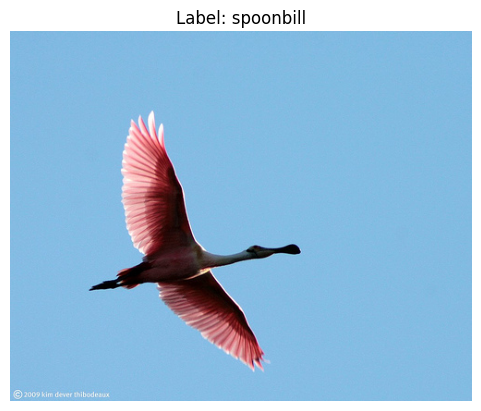

Random Training Images:


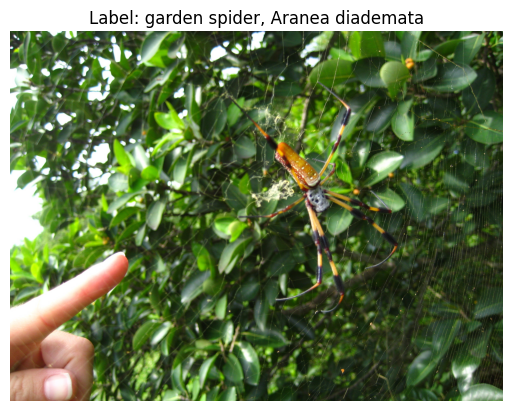

In [2]:
import json
import os
import random
import matplotlib.pyplot as plt
import cv2

# Load labels from JSON file
with open('/kaggle/input/imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

# Create a mapping from class ID to class name
id_to_class = {str(k): v for k, v in labels.items()}

# Function to display an image with its label
def show_image_with_label(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Directories containing the images
base_train_dir = '/kaggle/input/imagenet100'
val_dir = os.path.join(base_train_dir, 'val.X')
train_dirs = [os.path.join(base_train_dir, f'train.X{i}') for i in range(1, 5)]

# Helper function to get a random sample of images from a directory
def get_random_images(data_dirs, num_samples=5):
    images = []
    all_files = []
    for data_dir in data_dirs:
        for label_id in os.listdir(data_dir):
            class_name = id_to_class.get(label_id, 'Unknown')
            files = os.listdir(os.path.join(data_dir, label_id))
            all_files.extend([(os.path.join(data_dir, label_id, filename), class_name) for filename in files])

    selected_files = random.sample(all_files, num_samples)
    for image_path, class_name in selected_files:
        images.append((image_path, class_name))
    return images

# Get random images from validation set
val_images = get_random_images([val_dir], 1)

# Get random images from all training directories
train_images = get_random_images(train_dirs, 1)

# Display random validation images
print("Random Validation Images:")
for image_path, label in val_images:
    show_image_with_label(image_path, label)

# Display random training images
print("Random Training Images:")
for image_path, label in train_images:
    show_image_with_label(image_path, label)

# Setting up Dataset and Dataloaders

In [3]:
# Creating the transforms
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Create a custom dataset class
class MultiFolderDataset(Dataset):
    def __init__(self, folders, transform=None):
        self.samples = []
        self.transform = transform
        for folder in folders:
            for label_id in os.listdir(folder):
                class_name = id_to_class.get(label_id, 'Unknown')
                files = os.listdir(os.path.join(folder, label_id))
                self.samples.extend([(os.path.join(folder, label_id, filename), label_id) for filename in files])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(id_to_class.keys()))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = self.class_to_idx[label]
        return image, label

In [5]:
import torchvision.datasets as datasets
# Creating the Datasets
train_dataset = MultiFolderDataset(train_dirs, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [6]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Setting up the Model

In [7]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
!git clone https://github.com/dicarlolab/CORnet.git

Cloning into 'CORnet'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 155 (delta 13), reused 9 (delta 8), pack-reused 135 (from 1)
Receiving objects: 100% (155/155), 68.11 KiB | 3.24 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [9]:
# Navigate to the cloned repository folder
import os
os.chdir('/kaggle/working/CORnet')

# Install the package if needed
!pip install .

Processing /kaggle/working/CORnet
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for CORnet: filename=CORnet-0.1.0-py3-none-any.whl size=23228 sha256=d661e23101781d385205ff066356780c42374cfc98688a48e630e37abdd2b3c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-mvzzschf/wheels/ab/bb/f9/8716bf8cc3f23c0cd07d33b31c64ed0bc87023663d6be90ad5
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=0fabc2fddf2d587892fb8926badd5cf33fb0425768115e5e83ecf80488d587f3
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built CORnet fire


In [10]:
# Import the CORnet-S model architecture
from cornet import cornet_s

# Initialize the CORnet-S model
model = cornet_s()

In [12]:
# Replace the final layer to match ImageNet100 classes
import torch.nn as nn

num_classes = 100
model.module.decoder.linear = nn.Linear(in_features=model.module.decoder.linear.in_features, out_features=num_classes)

In [15]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch.nn as nn

# Load the pre-trained weights
checkpoint = torch.load("/kaggle/input/cornet-s/pytorch/default/1/cornet_s-1d3f7974.pth", map_location=device)

# Remove the final layer from the checkpoint to avoid size mismatch
del checkpoint['state_dict']['module.decoder.linear.weight']
del checkpoint['state_dict']['module.decoder.linear.bias']

# Load the rest of the weights into the model
model.load_state_dict(checkpoint['state_dict'], strict=False)  # strict=False ignores the missing final layer

In [19]:
import tqdm

model.to(device)
# Function to evaluate model performance (pre-training and post-training)
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct1 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(loader, desc="Evaluating"):  # Corrected tqdm usage
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item() * inputs.size(0)  # Update validation loss

            # Calculate top-1 and top-5 accuracy
            _, pred1 = outputs.topk(1, 1, True, True)
            _, pred5 = outputs.topk(5, 1, True, True)
            correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
            correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(loader.dataset)  # Compute validation loss
    top1_acc = correct1 / total  # Compute top-1 accuracy
    top5_acc = correct5 / total  # Compute top-5 accuracy

    print(f'Validation Loss: {epoch_val_loss:.4f}')
    print(f'Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}')
    
    return top1_acc, top5_acc

# Initial evaluation of pre-trained model
print("Evaluating pre-trained model before fine-tuning:")
evaluate_model(model, val_loader)

Evaluating pre-trained model before fine-tuning:


Evaluating: 100%|██████████| 157/157 [01:28<00:00,  1.78it/s]

Validation Loss: 1.3262
Top-1 Accuracy: 0.6374, Top-5 Accuracy: 0.8800


(0.6374, 0.88)

In [ ]:
# Ensure CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import necessary modules
import time
from tqdm import tqdm

# Move model to the appropriate device
model = model.to(device)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Training phase
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)  # Update running loss

        if i % 100 == 0:  # Print every 100 batches
            print(f"Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)  # Compute epoch loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct1 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item() * inputs.size(0)  # Update validation loss

            # Calculate top-1 and top-5 accuracy
            _, pred1 = outputs.topk(1, 1, True, True)
            _, pred5 = outputs.topk(5, 1, True, True)
            correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
            correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)  # Compute epoch validation loss
    top1_acc = correct1 / total  # Compute top-1 accuracy
    top5_acc = correct5 / total  # Compute top-5 accuracy

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_duration:.2f}s')
    print(f'Train Loss: {epoch_loss:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}')
    print(f'Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}')

    # Save the model checkpoint
    model_save_path = f'/kaggle/working/cornet_s_epoch{epoch+1}.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved at {model_save_path}')

print('Training complete')

# Implementing, Training, and Evaluating FGSM Attacks

In [19]:
import torchattacks
from tqdm import tqdm

model = model.to(device)
# FGSM Attack Setup for Testing
fgsm_attack = torchattacks.FGSM(model, eps=0.07)  # eps is the perturbation size

# Function to test model accuracy under FGSM attack
def test_fgsm(loader, model, attack):
    model.eval()
    correct = 0
    total = 0
    for inputs, labels in tqdm(loader, desc="Testing FGSM"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Generate adversarial examples
        adv_inputs = attack(inputs, labels)
        
        # Forward pass with adversarial examples
        outputs = model(adv_inputs)
        _, pred = outputs.max(1)
        
        # Accuracy calculation
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
    
    acc = correct / total
    print(f'FGSM Test Accuracy: {acc:.4f}')
    return acc

# Test the model on FGSM attacks before training
print("Testing on FGSM before adversarial training...")
fgsm_acc = test_fgsm(val_loader, model, fgsm_attack)


Testing on FGSM before adversarial training...


Testing FGSM: 100%|██████████| 157/157 [02:04<00:00,  1.26it/s]

FGSM Test Accuracy: 0.0756


In [39]:
import random
import torchattacks
from tqdm import tqdm

# FGSM Attack Setup for Training
fgsm_attack_train = torchattacks.FGSM(model, eps=0.07)  # Same epsilon as before

# Fraction of dataset to use in each epoch for adversarial training
batch_fraction = 0.3  # Adjust this fraction (e.g., 0.3 for 30%)

# Regularization parameter
alpha = 0.7  # weight of original loss; adjust as needed

def adversarial_train_fgsm_subset(loader, model, optimizer, criterion, attack, alpha, batch_fraction):
    model.train()
    
    # Calculate the number of batches to use based on the fraction
    total_batches = len(loader)
    subset_size = int(total_batches * batch_fraction)
    
    # Select a random subset of batches for this epoch
    batch_indices = random.sample(range(total_batches), subset_size)
    
    progress_bar = tqdm(enumerate(loader), total=total_batches, desc="FGSM Adversarial Training (Subset)")
    
    for i, (inputs, labels) in progress_bar:
        # Skip batches not in the selected subset
        if i not in batch_indices:
            continue
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Generate FGSM adversarial examples
        adv_inputs = attack(inputs, labels)
        
        # Forward pass on adversarial inputs (for original loss)
        optimizer.zero_grad()
        outputs_adv = model(adv_inputs)
        original_loss = criterion(outputs_adv, labels)
        
        # Forward pass on clean inputs (for regularization loss)
        outputs_clean = model(inputs)
        reg_loss = criterion(outputs_clean, labels)
        
        # Combined loss with regularization
        loss = original_loss * alpha + reg_loss * (1 - alpha)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update progress bar with loss
        progress_bar.set_postfix(loss=loss.item())

# Training loop (e.g., 5 epochs)
for epoch in range(5):
    adversarial_train_fgsm_subset(train_loader, model, optimizer, criterion, fgsm_attack_train, alpha=alpha, batch_fraction=batch_fraction)
    print(f"Epoch {epoch+1} completed.")
    
    # Save the model after each epoch
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
    print(f"Model saved for epoch {epoch+1}.")

FGSM Adversarial Training (Subset): 100%|██████████| 4063/4063 [46:44<00:00,  1.45it/s, loss=2.96]  


Epoch 1 completed.
Model saved for epoch 1.


FGSM Adversarial Training (Subset): 100%|██████████| 4063/4063 [37:28<00:00,  1.81it/s, loss=3.38]  


Epoch 2 completed.
Model saved for epoch 2.


FGSM Adversarial Training (Subset): 100%|██████████| 4063/4063 [37:08<00:00,  1.82it/s, loss=1.7]  


Epoch 3 completed.
Model saved for epoch 3.


FGSM Adversarial Training (Subset): 100%|██████████| 4063/4063 [37:04<00:00,  1.83it/s, loss=1.84]  


Epoch 4 completed.
Model saved for epoch 4.


FGSM Adversarial Training (Subset): 100%|██████████| 4063/4063 [37:06<00:00,  1.82it/s, loss=1.59] 


Epoch 5 completed.
Model saved for epoch 5.


In [40]:
import torchattacks
from tqdm import tqdm
import torch

# FGSM Attack Setup
fgsm_attack = torchattacks.FGSM(model, eps=0.07)

# Function to test model accuracy on FGSM attack
def test_fgsm(loader, model, attack):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # Iterate through the data loader with progress bar
    for inputs, labels in tqdm(loader, desc="Testing FGSM"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate adversarial examples
        adv_inputs = attack(inputs, labels)

        # Get model outputs from adversarial inputs
        outputs = model(adv_inputs)
        _, pred = outputs.max(1)  # Get predicted class
        
        correct += pred.eq(labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Total number of labels

    # Calculate accuracy
    acc = correct / total
    print(f'FGSM Test Accuracy: {acc:.4f}')
    return acc

# Function to evaluate model performance (pre-training and post-training)
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct1 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating on Clean Data"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item() * inputs.size(0)  # Update validation loss

            # Calculate top-1 and top-5 accuracy
            _, pred1 = outputs.topk(1, 1, True, True)
            _, pred5 = outputs.topk(5, 1, True, True)
            correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
            correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(loader.dataset)  # Compute validation loss
    top1_acc = correct1 / total  # Compute top-1 accuracy
    top5_acc = correct5 / total  # Compute top-5 accuracy

    print(f'Validation Loss: {epoch_val_loss:.4f}')
    print(f'Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}')
    
    return top1_acc, top5_acc

# Re-test the model on FGSM attacks after adversarial training
print("Re-testing on FGSM after adversarial training...")
fgsm_acc_after = test_fgsm(val_loader, model, fgsm_attack)

# Evaluate the model on regular data (without FGSM) to validate its accuracy on clean data
print("Testing on clean data...")
evaluate_model(model, val_loader)

Re-testing on FGSM after adversarial training...


Testing FGSM: 100%|██████████| 157/157 [01:34<00:00,  1.66it/s]


FGSM Test Accuracy: 0.1832
Testing on clean data...


Evaluating on Clean Data: 100%|██████████| 157/157 [00:53<00:00,  2.95it/s]

Validation Loss: 2.0381
Top-1 Accuracy: 0.5026, Top-5 Accuracy: 0.7506


(0.5026, 0.7506)

# Implementing and Evaluating PGD attacks

In [13]:
import torch.nn as nn

model_path = '/kaggle/input/cornet-s-trained-on-imagenet100/pytorch/default/1/cornet_s_epoch5.pth'  # Path to the model
checkpoint = torch.load(model_path, map_location=device)  # Use 'cpu' if not using GPU

model.load_state_dict(checkpoint)  # Load the state dictionary

<All keys matched successfully>

In [ ]:
# Print the weights of a specific layer (e.g., first conv layer)
print(model.module.V1.conv1.weight)

In [15]:
!pip install torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.9.0 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you ha

In [18]:
from tqdm import tqdm
import torchattacks

model.to(device)

# PGD Attack
pgd_attack = torchattacks.PGD(model, eps=0.001, alpha=2/255, steps=40)

# Function to test adversarial accuracy
def adversarial_test(attack, loader, attack_name):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc=f"Adversarial Test ({attack_name})"):
        inputs, labels = inputs.to(device), labels.to(device)
        adv_inputs = attack(inputs, labels)
        outputs = model(adv_inputs)
        
        _, pred = outputs.max(1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
    
    acc = correct / total
    print(f'{attack_name} Accuracy: {acc:.4f}')
    return acc

# Evaluate model with PGD attack
pgd_acc = adversarial_test(pgd_attack, val_loader, "PGD")

Adversarial Test (PGD): 100%|██████████| 157/157 [31:41<00:00, 12.11s/it]

PGD Accuracy: 0.1782


In [24]:
# PGD Attack Setup for Training
pgd_attack_train = torchattacks.PGD(model, eps=0.3, alpha=2/255, steps=10)

from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()  # for scaling the loss

def adversarial_train_pgd(loader, model, optimizer, criterion, attack):
    model.train()
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="PGD Adversarial Training")
    
    for i, (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Generate PGD adversarial examples
        adv_inputs = attack(inputs, labels)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with autocast():
            outputs = model(adv_inputs)
            loss = criterion(outputs, labels)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        progress_bar.set_postfix(loss=loss.item())

# Training loop (e.g., 10 epochs)
for epoch in range(10):
    adversarial_train_pgd(train_loader, model, optimizer, criterion, pgd_attack_train)
    print(f"Epoch {epoch+1} completed.")


PGD Adversarial Training: 100%|██████████| 4063/4063 [3:43:21<00:00,  3.30s/it, loss=3.35]  


Epoch 1 completed.


PGD Adversarial Training:   3%|▎         | 124/4063 [06:31<3:27:14,  3.16s/it, loss=3.18]


KeyboardInterrupt: 

In [26]:
# Re-test the model under PGD attack after adversarial training
def adversarial_test(loader, attack, model, attack_name):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc=f"Adversarial Test ({attack_name})"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate adversarial examples
        adv_inputs = attack(inputs, labels)

        # Forward pass with adversarial examples
        outputs = model(adv_inputs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"{attack_name} Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Evaluate accuracy after training with PGD attack
pgd_acc_after_training = adversarial_test(val_loader, pgd_attack_train, model, "PGD After Training")

Adversarial Test (PGD After Training): 100%|██████████| 157/157 [08:06<00:00,  3.10s/it]

PGD After Training Accuracy: 16.84%


In [29]:
# Re-test the model on clean (non-adversarial) data
def test_clean(loader, model):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc="Testing on Clean Data"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass without adversarial examples
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"Clean Data Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Evaluate model on clean data
clean_acc = test_clean(val_loader, model)

Testing on Clean Data: 100%|██████████| 157/157 [00:59<00:00,  2.64it/s]

Clean Data Accuracy: 1.10%


# Implementing and Evaluating Carlini Wagner Attacks

In [22]:
import torchattacks
from tqdm import tqdm

# CW Attack Setup
cw_attack = torchattacks.CW(model, c=1e-3, kappa=0, steps=100, lr=0.01)

# Function to test model accuracy on CW attack with TQDM
def adversarial_test(attack, loader, attack_name):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    # Iterate through the data loader with a progress bar
    for inputs, labels in tqdm(loader, desc=f"Adversarial Test ({attack_name})"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Generate adversarial examples
        adv_inputs = attack(inputs, labels)
        
        # Get model outputs from adversarial inputs
        outputs = model(adv_inputs)
        _, pred = outputs.max(1)  # Get predicted class
        
        correct += pred.eq(labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Total number of labels
    
    # Calculate accuracy
    acc = correct / total
    print(f'{attack_name} Accuracy: {acc:.4f}')
    return acc

# Test model accuracy on CW attack
cw_acc = adversarial_test(cw_attack, val_loader, "CW")
print(f'Accuracy under CW Attack: {cw_acc * 100:.2f}%')

Adversarial Test (CW): 100%|██████████| 157/157 [40:49<00:00, 15.60s/it] 

CW Accuracy: 0.1318
Accuracy under CW Attack: 13.18%
